In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import keras
import h5py

%matplotlib inline

# np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras import regularizers
from keras.utils.io_utils import HDF5Matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.training_utils import multi_gpu_model


sns.set(style='white', context='notebook', palette='deep')

/home/yunhao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [30]:
# Credit to DeepLearning.AI Course Staff

def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train, Y_train, X_test, Y_test, classes = load_dataset()

In [3]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1080, 64, 64, 3)
(120, 64, 64, 3)
(1, 1080)
(1, 120)


In [5]:
Y_train = to_categorical(Y_train, num_classes = 6)
Y_test = to_categorical(Y_test, num_classes = 6)

In [6]:
Y_train = Y_train[0]
Y_test = Y_test[0]
print(Y_train.shape)
print(Y_test.shape)

(1080, 6)
(120, 6)


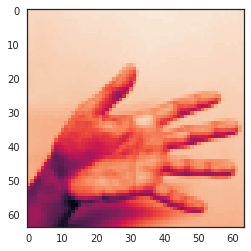

In [9]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [10]:
# v1
# A good model used on MNIST dataset

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', 
                 activation ='relu', input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.30))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.30))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.30))


model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.30))

model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.30))

model.add(Dense(6, activation = "softmax"))

In [11]:
# v2 
# Regularization(both L1 and L2 ) and Dropout performance very badly in this task.
# We choose to implement data augmentation. 

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (4, 4), padding = 'Same', 
                 activation ='relu', input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 64, kernel_size = (2, 2), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(4, 4), strides=(8, 8), padding='valid'))
# model.add(Dropout(0.1))  

model.add(Conv2D(filters = 128, kernel_size = (2, 2), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (2, 2), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
# model.add(Dropout(0.1))


model.add(Flatten())

model.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.1))

model.add(Dense(6, activation = "softmax"))

In [31]:
# v3 Final

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (4, 4), padding = 'Same', 
                 activation ='relu', input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 64, kernel_size = (4, 4), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(4, 4), strides=(8, 8), padding='valid'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size = (2, 2), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (2, 2), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
# model.add(Dropout(0.1))


model.add(Flatten())

model.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.1))

model.add(Dense(6, activation = "softmax"))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        65600     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         32896     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         65664     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
__________

In [21]:
# optimizer = RMSprop(lr=2e-3, rho=0.9, epsilon=1e-08, decay=0.02)
# optimizer = Adagrad(lr=0.001, epsilon=None, decay=0.0)
optimizer = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                 decay=0.02, amsgrad=False)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-4)

Instead of using regularization on CNN models, We synthesis more train images by zooming and shifting.

In [22]:
# datagen = ImageDataGenerator(
#         rotation_range=60,  
#         zoom_range=0.5,
#         width_shift_range=0.2,  
#         height_shift_range=0.2)

datagen = ImageDataGenerator(
        rotation_range=15,  
        zoom_range=0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1)

datagen.fit(X_train)

    v2, zoom_range=0.1
     - 23s - loss: 0.0267 - acc: 0.9963 - val_loss: 0.2377 - val_acc: 0.9500
    v2, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1
     - 23s - loss: 0.3041 - acc: 0.8956 - val_loss: 0.1802 - val_acc: 0.9417
    v2, rotation_range=15, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, batch_size = 4096
     - 10s - loss: 0.2163 - acc: 0.9321 - val_loss: 0.1476 - val_acc: 0.9750
    v3, rotation_range=15, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, batch_size = 3072
     - 13s - loss: 0.0684 - acc: 0.9802 - val_loss: 0.0375 - val_acc: 0.9917

In [23]:
# Compile the model
# model = multi_gpu_model(model, gpus=2) # Uncomment this line if you have multiple GPUs
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
%%time
# Fit the model
epochs = 30
batch_size = 3072 # decrease it if your GPU RAM is less than 8GB

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 2, steps_per_epoch = X_train.shape[0] / batch_size * 50, 
                                callbacks=[learning_rate_reduction])

Epoch 1/30
 - 15s - loss: 3.7162 - acc: 0.3385 - val_loss: 1.6357 - val_acc: 0.4500
Epoch 2/30
 - 13s - loss: 1.1962 - acc: 0.5831 - val_loss: 0.6246 - val_acc: 0.7667
Epoch 3/30
 - 13s - loss: 0.6518 - acc: 0.7600 - val_loss: 0.3833 - val_acc: 0.8750
Epoch 4/30
 - 13s - loss: 0.4539 - acc: 0.8401 - val_loss: 0.3097 - val_acc: 0.8917
Epoch 5/30
 - 13s - loss: 0.3584 - acc: 0.8748 - val_loss: 0.2489 - val_acc: 0.9083
Epoch 6/30
 - 13s - loss: 0.2985 - acc: 0.8990 - val_loss: 0.2018 - val_acc: 0.9333
Epoch 7/30
 - 13s - loss: 0.2594 - acc: 0.9123 - val_loss: 0.1867 - val_acc: 0.9333
Epoch 8/30
 - 13s - loss: 0.2195 - acc: 0.9289 - val_loss: 0.1527 - val_acc: 0.9500
Epoch 9/30
 - 13s - loss: 0.1882 - acc: 0.9384 - val_loss: 0.1292 - val_acc: 0.9417
Epoch 10/30
 - 13s - loss: 0.1692 - acc: 0.9459 - val_loss: 0.1196 - val_acc: 0.9500
Epoch 11/30
 - 13s - loss: 0.1508 - acc: 0.9516 - val_loss: 0.0815 - val_acc: 0.9667
Epoch 12/30
 - 13s - loss: 0.1359 - acc: 0.9548 - val_loss: 0.0795 - val_a

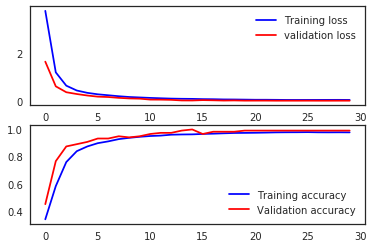

In [25]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

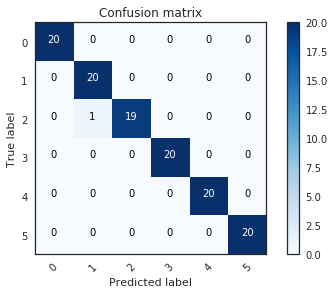

In [26]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(6)) 

IndexError: index 1 is out of bounds for axis 0 with size 1

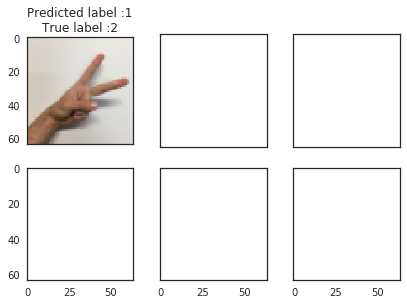

In [27]:
# Display some error results 
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            fig.tight_layout()
            ax[row,col].imshow((img_errors[error]).reshape((64,64,3)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

**There is index error because we only failed on 1 image! **

**Our result is much better than the result from the model builded during the CNN application tutorial of DeepLearning.AI Coursera courses.**

<table> 
<tr>
    <td> 
    **Our Train Accuracy =**
    </td>

    <td> 
      0.9790
    </td> 
</tr>
<tr>
    <td> 
    **Our Test Accuracy =**
    </td>

    <td> 
      0.9917
    </td> 
</tr>
<tr>
    <td> 
    **Tutorial Train Accuracy   =**
    </td>

    <td> 
      0.9407
    </td> 
</tr> 

<tr>
    <td> 
    **Tutorial Test Accuracy   =**
    </td>

    <td> 
      0.7833
    </td> 
</tr> 
</table>